In [2]:
from comet_ml import Experiment
from comet_ml import OfflineExperiment
import pandas as pd 
from cfg import *
import cv2
import numpy as np
from loader import data_pipe
from skimage.feature import texture
import glob
from personal_cls import run
import lightgbm as lgb
import random

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC
from sklearn.model_selection import cross_validate
from loader import numerical_loader
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE 
from cfg import *
import random
import matplotlib.pyplot as plt

from loader import *
from mri_cls import clf as img_clf
from personal_cls import clf as num_clf

In [3]:
X_num, y = numerical_loader(drop_name=False)
X_num = pd.DataFrame(X_num)
X_num['label'] = y
X_num[0] = X_num[0].astype(str)
X_num = X_num.rename(columns={0: 'fname'})

Index(['病歷號 (yellow in WHO grade I file) ', 'Gender (M:1 F:0)', 'Age',
       'ADC tumor', 'Adjacent bone invasion', 'GTR', 'STR',
       'Peritumoral edema (Yes:1 or No:1)',
       'Heterogeneous enhancement (Yes:1 or No:0)', 'Calcification',
       'Reactive hyperostosis', 'Dural tail sign', 'Cystic change or necrosis',
       'Maximal diameter', 'Tumor volume (cm3)', 'x', 'y', 'z',
       'Special histology_0', 'Special histology_1', 'Special histology_3',
       'Simpson grade resection_1', 'Simpson grade resection_2',
       'Simpson grade resection_3', 'Simpson grade resection_4'],
      dtype='object')
(25,) (25,)
Number of Patients and feature : 57 17
Number of Case 1 and Case 2 : 44 13
-------------------------
Using feature:
0 | 病歷號 (yellow in WHO grade I file) 
1 | Gender (M:1 F:0)
3 | ADC tumor
5 | GTR
6 | STR
7 | Peritumoral edema (Yes:1 or No:1)
8 | Heterogeneous enhancement (Yes:1 or No:0)
9 | Calcification
11 | Dural tail sign
13 | Maximal diameter
14 | Tumor volume (cm

In [4]:
dtype = ['T1', 'T1c', 'T2', 'Flair']
# dtype = ['Flair']
X_img, y = img_features(dtype, return_df=True)
X_img['fname'] =  X_img['fname'].apply(lambda raw:raw.split('/')[-1][:-4]+'.0')

In [5]:
X_ALL = pd.merge(X_num, X_img, how='inner', on='fname')
X_fname = X_ALL.pop('fname')

def run(X, cls, ros=False, thr=.5, seed=None):
    met =  ['accuracy', 'precision', 'recall', 'roc_auc', 'fpr', 'tpr']
    metric = ['train_' + val for val in met] + ['test_' + val for val in met]
    result = {}
    for m in metric:result[m] = []

    skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True, random_state=seed)
    
    y = X.pop('label')
    svm_scores = pd.DataFrame(X_fname.copy())
    svm_scores['prob'] = ""
    
    for train_idx, val_idx in skf.split(X, y):
        Xnum_train, Xnum_test = X.loc[train_idx], X.loc[val_idx]
        y_train, y_test = y.loc[train_idx], y.loc[val_idx]

        Ximg_train = Xnum_train.pop('img_feature').to_list()
        Ximg_test = Xnum_test.pop('img_feature').to_list()
        
        Ximg_train = np.array(Ximg_train)
        Ximg_test = np.array(Ximg_test)

        if ros:  Ximg_for_train, y_for_train = SMOTE(random_state=42).fit_resample(Ximg_train, y_train)

        pos = 1
        img_clf.fit(Ximg_for_train, y_for_train)
        img_probs_train = img_clf.decision_function(Ximg_train)
        img_probs_test = img_clf.decision_function(Ximg_test)
        img_probs_train = np.expand_dims(img_probs_train, 1)
        img_probs_test = np.expand_dims(img_probs_test, 1)

        num_clf.fit(Xnum_train, y_train)
        num_probs_train = num_clf.predict_proba(Xnum_train)[:, pos:]
        num_probs_test = num_clf.predict_proba(Xnum_test)[:, pos:]

        probs_train = np.concatenate([img_probs_train, num_probs_train], axis=1)
        probs_test = np.concatenate([img_probs_test, num_probs_test], axis=1)
        
        cls.fit(probs_train, y_train)
        y_pred = cls.predict_proba(probs_test)
        
        # svm_scores['prob'].loc[val_idx] = y_pred[:, 0]
        svm_scores['prob'].loc[val_idx] = y_pred[:, 1]

        fpr, tpr, _ = metrics.roc_curve(y_test, y_pred[:, 1])
        y_pred = [1 if logit>thr else 0 for logit in y_pred[:, 1]]

        result['test_accuracy'].append(metrics.accuracy_score(y_test, y_pred, ),)
        result['test_precision'].append(metrics.precision_score(y_test, y_pred, zero_division=1),)
        result['test_recall'].append(metrics.recall_score(y_test, y_pred, zero_division=1),)
        result['test_roc_auc'].append(metrics.roc_auc_score(y_test, y_pred),)
        result['test_fpr'].append(fpr)
        result['test_tpr'].append(tpr)
    # svm_scores['n'] = svm_scores2
    return result, svm_scores

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wtyo1768/pr-classifier/8cbd1817926449c38a7c61ed959a60a2



accuracy |	 0.9106060606060605
precision |	 0.8533333333333333
recall |	 0.8333333333333333
roc_auc |	 0.8805555555555555


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: All files uploaded, waiting for confirmation they have been all received


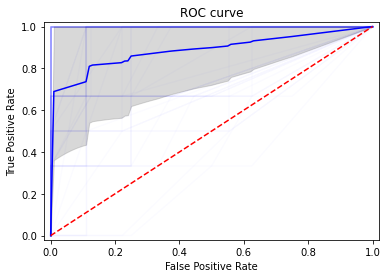

In [27]:
experiment = Experiment(
        api_key=COMET_APT_KEY,
        project_name=COMET_PROJECT_NAME,
        workspace=COMET_WORK_SPACE,
        display_summary_level=0,
        log_code=False,
        # disabled=True, 
)
experiment.add_tag('ensemble')
met =  ['accuracy', 'precision', 'recall', 'roc_auc']
metric = ['test_' + val for val in met]
base_fpr = np.linspace(0, 1, 101)
tprs = []
total_result = {}
for m in metric: total_result[m] = []

# clf = LogisticRegression(
#     class_weight='balanced', 
#     max_iter=100,
#     penalty='none',
# )
clf = RandomForestClassifier(max_depth=1, random_state=0, class_weight='balanced', 
                             n_estimators=11)
svm_scores = []
for i in range(NUM_RANDOM_STATE):
    result, scores = run(X_ALL.copy(), clf, thr=.50, seed=SEEDS[i], ros=True)
    for m in metric: total_result[m].append(result[m])
    for j in range(len(result['test_fpr'])):
        plt.plot(result['test_fpr'][j], result['test_tpr'][j], 'b', alpha=0.015)
        tpr = np.interp(base_fpr, result['test_fpr'][j], result['test_tpr'][j])
        tpr[0] = 0.0
        tprs.append(tpr)
    svm_scores.append(scores)
    # break 
        
for m in met: 
    print(m ,'|\t',
        #   np.mean(result[f'train_{m}']),
          np.mean(result[f'test_{m}']))
    experiment.log_metric(m, np.mean(result[f'test_{m}']))
tprs = np.array(tprs)        
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
 
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std
experiment.log_curve('ROC_CURVE', base_fpr, mean_tprs)
plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')
experiment.log_parameters({'seeds':SEEDS})
experiment.log_figure('ROC curve', figure=plt)
experiment.end()
plt.show()
# mean_tprs.tolist()

In [36]:
from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['fname'], how='outer'), svm_scores)
fname = df_merged.pop('fname')

print(df_merged.shape)
avg_score = df_merged.agg("mean", axis=1)
avg_score = pd.DataFrame(avg_score)
avg_score['Patient ID'] = fname.to_list()
avg_score.to_csv('./svm_socres.csv')
# avg_score.max(), avg_score.min()

(56, 15)


/home/rockyo/anaconda3/envs/brain-pr/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'prob_x'} in the result is deprecated and will raise a MergeError in a future version.
  


In [37]:
avg_score.pop('Patient ID')

0     10027124.0
1     11009708.0
2     11775010.0
3     12261283.0
4     13488672.0
5     13661917.0
6     14041674.0
7     15176128.0
8     15525495.0
9     15552568.0
10    16113441.0
11    17244854.0
12    18456622.0
13    18765851.0
14    19315335.0
15    19425238.0
16    20483981.0
17    20947834.0
18    21105320.0
19    21372392.0
20    21381973.0
21    22296689.0
22    25385854.0
23    25825974.0
24    26073373.0
25    26082459.0
26    26434694.0
27    26608196.0
28    26658418.0
29    27103788.0
30    27237207.0
31    27472711.0
32    27607264.0
33    27710844.0
34    27931321.0
35    28248060.0
36    28267864.0
37    28358688.0
38    29177415.0
39    29285707.0
40    29301889.0
41    29729120.0
42    29816081.0
43    30268702.0
44    30517836.0
45    30732894.0
46    30871154.0
47    30920239.0
48    31001430.0
49    31046225.0
50    31406726.0
51    31445157.0
52    52847319.0
53    24237245.0
54    80190941.0
55    33056266.0
Name: Patient ID, dtype: object

In [38]:
avg_score.max(), avg_score.min()

(0    0.93083
 dtype: float64,
 0    0.049295
 dtype: float64)

In [29]:
mean_tprs.tolist()

[0.0,
 0.6891555555555555,
 0.6938666666666666,
 0.6985777777777776,
 0.7032888888888887,
 0.708,
 0.7127111111111111,
 0.7174222222222221,
 0.7221333333333332,
 0.7268444444444444,
 0.7315555555555555,
 0.7362666666666665,
 0.8096666666666666,
 0.8157416666666664,
 0.8170166666666664,
 0.8182916666666665,
 0.8195666666666664,
 0.8208416666666664,
 0.8221166666666665,
 0.8233916666666665,
 0.8246666666666664,
 0.8259416666666665,
 0.8272166666666665,
 0.8348694444444443,
 0.8357730158730157,
 0.8588988095238093,
 0.8608097883597882,
 0.862720767195767,
 0.8646317460317458,
 0.8665427248677247,
 0.8684537037037035,
 0.8703646825396822,
 0.8722756613756611,
 0.8741866402116402,
 0.876097619047619,
 0.8780085978835976,
 0.8799195767195764,
 0.8818305555555555,
 0.8834926455026454,
 0.8849058465608463,
 0.8863190476190475,
 0.8877322486772485,
 0.8891454497354495,
 0.8905586507936507,
 0.8919718518518518,
 0.8932517195767193,
 0.8944249206349205,
 0.8955981216931216,
 0.8967713227513228,
 